In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gold-stock-prices/goldstock v2.csv
/kaggle/input/gold-stock-prices/goldstock v1.csv


# I- Packages

In [ ]:
!pip install pandas_ta
!pip install mplfinance

In [125]:
import pandas_ta as ta

import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf

from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Flatten, Dense,Dropout,LSTM,GRU,InputLayer,Bidirectional 

from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.models import Sequential


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import clear_output

# II- Data

## II.01 Preprocess 

In [ ]:
all_data = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_stocks.csv')
# val  = pd.read_csv('/kaggle/input/gold-stock-prices/goldstock v2.csv')

In [14]:
# data = all_data[all_data['Symbol'] == 'MMM'] # MecroSoft Stocs
data = all_data
data = data.reset_index()

data.set_index(data.Date, inplace=True)

# data = data.drop(['Symbol','index','Date'],axis=1)
data = data.drop(['Date'],axis=1)


data.index = pd.to_datetime(data.index)

data = data.drop(['index'],axis=1)

bk_data = data

In [15]:
arr = [pd.DataFrame(data[data['Symbol'] == s]) for s in data['Symbol'].unique()]
arr[0]

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2010-01-04,MMM,44.016727,69.414719,69.774246,69.122070,69.473244,3640265.0
2010-01-05,MMM,43.741028,68.979935,69.590302,68.311035,69.230766,3405012.0
2010-01-06,MMM,44.361355,69.958191,70.735786,69.824417,70.133781,6301126.0
2010-01-07,MMM,44.393166,70.008362,70.033447,68.662209,69.665550,5346240.0
2010-01-08,MMM,44.705975,70.501671,70.501671,69.648827,69.974915,4073337.0
...,...,...,...,...,...,...,...
2024-08-27,MMM,131.399994,131.399994,132.619995,130.949997,131.320007,2878500.0
2024-08-28,MMM,131.610001,131.610001,132.619995,131.149994,131.399994,3274000.0
2024-08-29,MMM,132.910004,132.910004,133.179993,131.339996,131.649994,2992600.0


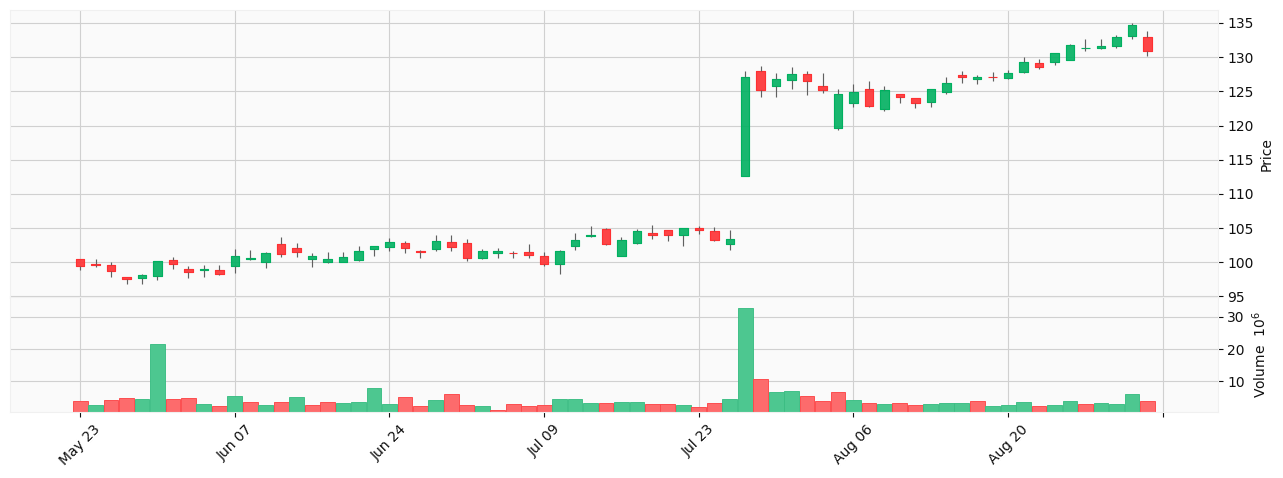

In [16]:
mpf.plot(arr[0][-70:],type='candle',style="yahoo",volume=True,figratio=(35,12))

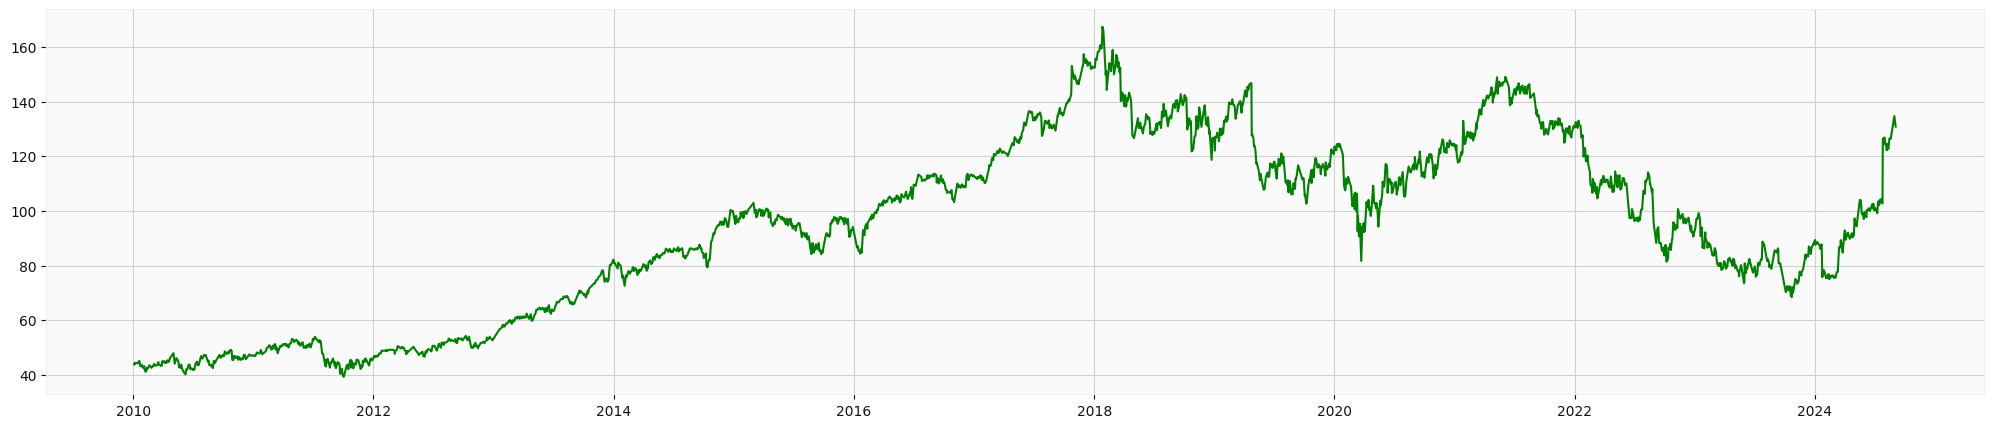

In [17]:
fig, ax = plt.subplots(figsize=(25,5))

ax.plot(arr[0]["Adj Close"], color='green')

In [18]:
arr[0].tail(1)

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2024-09-03,MMM,130.850006,130.850006,133.769897,130.220001,133.009995,3842585.0


In [19]:
arr[0].describe()

,Adj Close,Close,High,Low,Open,Volume
count,3691.000000,3691.000000,3691.000000,3691.000000,3691.000000,3.691000e+03
mean,94.258393,119.988378,120.919992,118.995272,119.986402,3.682221e+06
std,31.918035,36.359498,36.585134,36.129679,36.371121,2.937095e+06
min,39.295200,59.306019,60.351170,57.382942,58.637123,7.785960e+05
25%,68.502777,85.121239,86.020065,84.435619,85.037628,2.386438e+06
50%,96.626320,122.650505,124.021736,121.262543,122.692307,3.104577e+06
75%,119.346836,146.864548,148.081100,145.815216,146.918900,4.110472e+06
max,167.384384,216.245819,217.198990,214.021744,216.145493,6.043675e+07


In [20]:
arr[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3691 entries, 2010-01-04 to 2024-09-03
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Symbol     3691 non-null   object 
 1   Adj Close  3691 non-null   float64
 2   Close      3691 non-null   float64
 3   High       3691 non-null   float64
 4   Low        3691 non-null   float64
 5   Open       3691 non-null   float64
 6   Volume     3691 non-null   float64
dtypes: float64(6), object(1)
memory usage: 230.7+ KB


<Axes: >

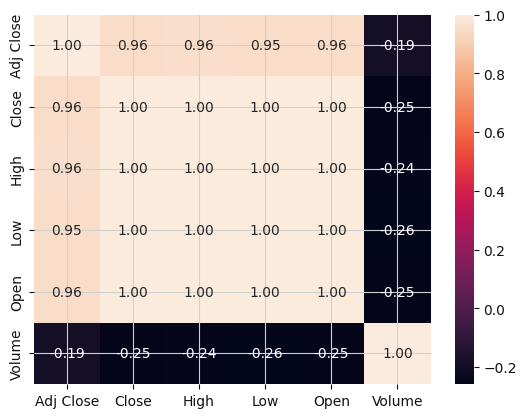

In [21]:
sns.heatmap(arr[0].drop("Symbol",axis=1).corr(),annot=True, fmt=".2f")

In [22]:
for i in range(len(arr)):
    arr[i] = arr[i].drop(columns=['Volume','Close',"Symbol",'High','Low',"Open"],axis=1)

arr[0].tail(1)

,Adj Close
Date,
2024-09-03,130.850006


<div dir="rtl">

- ### Relative Strength Index (RSI)

    - #### أهمية
يستخدم لقياس زخم السوق وتحديد حالات الشراء المفرط أو البيع المفرط. يمكن أن يساعد في تحديد نقاط التحول المحتملة في الاتجاه.

    - #### الاستخدام
عندما يكون المؤشر فوق 70، قد يشير إلى حالة شراء مفرطة، وعندما يكون تحت 30، قد يشير إلى حالة بيع مفرطة.

- ### Moving Average Convergence Divergence (MACD)

    - #### أهمية
يعتبر من أقوى المؤشرات لتحديد اتجاهات السوق، خاصةً مع إشارات التقاطع بين خطوط MACD وخط الإشارة، مما يساعد في تحديد الفرص التجارية.

    - #### الاستخدام
إذا تجاوز خط MACD خط الإشارة من الأسفل إلى الأعلى، قد يشير إلى فرصة شراء، والعكس صحيح.

- ### Bollinger Bands

    - #### أهمية
يساعد في قياس تقلبات السوق وتحديد المستويات التي قد يشهد فيها السوق انعكاسات. يمكن أن يكون مفيدًا في تحديد لحظات الارتفاع أو الهبوط المفاجئ.

    - #### الاستخدام
إذا تجاوز السعر النطاق العلوي، فقد يكون في حالة شراء مفرط، وإذا تجاوز النطاق السفلي، فقد يكون في حالة بيع مفرط.

- ### المتوسط المتحرك الأسي (EMA)

    - #### EMA قصير الأجل (EMAF)
يحسب المتوسط المتحرك الأسي لفترة زمنية قصيرة (20 يومًا في هذا المثال). يمكن أن يساعد في تحديد اتجاهات السوق قصيرة الأجل ويساعد في اكتشاف نقاط الدخول والخروج السريعة من السوق.

    - #### EMA متوسط الأجل (EMAM)
يحسب المتوسط المتحرك الأسي لفترة زمنية متوسطة (100 يوم في هذا المثال). يستخدم عادة لفهم الاتجاهات العامة والمتوسطة الأجل في السوق. يمكن أن يساعد في تجنب الضوضاء والتقلبات قصيرة الأجل والتركيز على التحركات الأهم.

    - #### EMA طويل الأجل (EMAS)
يحسب المتوسط المتحرك الأسي لفترة زمنية طويلة (150 يومًا في هذا المثال). يساعد في تحليل الاتجاهات طويلة الأجل ويُستخدم عادةً لتأكيد الاتجاهات الرئيسية في السوق.

</div>


## II.02 Feature Selection

In [23]:
for i in range(len(arr)):
    arr[i]['EMAF'] = ta.ema(arr[i]["Adj Close"], length=20) 
    arr[i]['EMAM'] = ta.ema(arr[i]["Adj Close"], length=100)
    arr[i]['EMAS'] = ta.ema(arr[i]["Adj Close"], length=150)

    # arr[i]['RSI'] = ta.rsi(arr[i]["Adj Close"], length=14) 

    MACD = ta.macd(arr[i]["Adj Close"], fast=12, slow=26, signal=9)

    arr[i]['MACD'] = MACD['MACD_12_26_9']
    arr[i]['MACD_Signal'] = MACD['MACDs_12_26_9']
    # arr[i]['MACD_Hist'] =  MACD['MACDh_12_26_9']

    bbands = ta.bbands(arr[i]["Adj Close"], length=20, std=2)
    arr[i]['BB_upper'] = bbands['BBL_20_2.0']  
    arr[i]['BB_middle'] = bbands['BBM_20_2.0']  
    arr[i]['BB_lower'] = bbands['BBU_20_2.0']  
    
    arr[i] = arr[i].dropna()

In [24]:
arr[0] 

,Adj Close,EMAF,EMAM,EMAS,MACD,MACD_Signal,BB_upper,BB_middle,BB_lower
Date,,,,,,,,,
2010-08-06,46.877476,45.752291,44.145397,43.959775,0.974323,0.891782,43.119576,45.642861,48.166145
2010-08-09,47.274899,45.897302,44.207368,44.003684,0.974470,0.908320,43.273222,45.797794,48.322365
2010-08-10,46.780830,45.981447,44.258327,44.040467,0.924067,0.911469,43.371948,45.893386,48.414823
2010-08-11,45.164368,45.903630,44.276269,44.055353,0.745099,0.878195,43.446416,45.921580,48.396745
2010-08-12,45.116035,45.828621,44.292898,44.069402,0.592534,0.821063,43.516575,45.947089,48.377602
...,...,...,...,...,...,...,...,...,...
2024-08-27,131.399994,124.894893,107.119257,101.692770,4.880864,5.015044,121.006718,126.210081,131.413444
2024-08-28,131.610001,125.534427,107.604223,102.089025,4.831476,4.978331,120.738012,126.447277,132.156541
2024-08-29,132.910004,126.236863,108.105327,102.497250,4.841427,4.950950,120.450508,126.803183,133.155858


<Axes: >

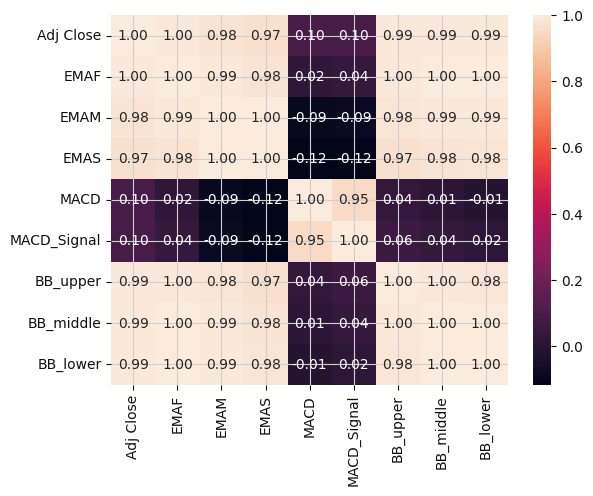

In [26]:
sns.heatmap(arr[0].corr(),annot=True, fmt=".2f")

In [197]:
data = data.drop(["RSI","MACD_Hist"],axis=1)

In [27]:
val_data = arr[-1]
data = arr[:-1]

val_data

,Adj Close,EMAF,EMAM,EMAS,MACD,MACD_Signal,BB_upper,BB_middle,BB_lower
Date,,,,,,,,,
2013-03-01,31.773975,29.992082,28.994759,28.840312,0.451663,0.400484,28.047668,29.989681,31.931694
2013-03-04,31.544413,30.139923,29.045248,28.876128,0.519930,0.424373,28.218656,30.143041,32.067426
2013-03-05,31.489305,30.268435,29.093645,28.910739,0.563094,0.452117,28.442062,30.293187,32.144313
2013-03-06,31.085247,30.346227,29.133082,28.939541,0.558263,0.473346,28.735248,30.422212,32.109176
2013-03-07,31.737244,30.478705,29.184650,28.976597,0.600126,0.498702,29.053206,30.584296,32.115385
...,...,...,...,...,...,...,...,...,...
2024-08-27,182.100006,182.408727,177.095103,176.418562,0.798978,1.446758,177.383264,183.127500,188.871736
2024-08-28,182.910004,182.456467,177.210249,176.504541,0.756828,1.308772,177.701728,183.271001,188.840273
2024-08-29,182.889999,182.497756,177.322720,176.589117,0.713584,1.189735,177.735834,183.294501,188.853168


In [28]:
data_arr = []
for i in range(len(data)):
    data_arr.append(data[i].to_numpy()) 


np_val = val_data.to_numpy()
data_arr[0].shape,np_val.shape

((3542, 9), (2897, 9))

## II.03 Data Scaling

In [29]:
def y_invert(vec): #invert scaling
    
    inverted_data = np.zeros((len(vec),9))
    inverted_data[:, 0] = vec.reshape(1, -1)
    

    inverted_column = std_scaler.inverse_transform(inverted_data)[:, 0]
    
    return inverted_column

In [30]:
data_arr[0]

array([[ 46.87747574,  45.75229129,  44.14539745, ...,  43.11957614,
         45.64286079,  48.16614545],
       [ 47.27489853,  45.8973015 ,  44.20736777, ...,  43.27322211,
         45.79779377,  48.32236543],
       [ 46.78083038,  45.98144711,  44.25832742, ...,  43.37194793,
         45.8933857 ,  48.41482346],
       ...,
       [132.91000366, 126.23686303, 108.10532727, ..., 120.45050796,
        126.80318298, 133.15585801],
       [134.69000244, 127.04192392, 108.63175648, ..., 120.18369798,
        127.30925941, 134.43482085],
       [130.8500061 , 127.40459842, 109.07172182, ..., 120.54580761,
        127.65466728, 134.76352696]])

In [31]:
std_scaler = MinMaxScaler()
std_scaler.fit(data_arr[4])

MinMaxScaler()

In [32]:
std_val =  std_scaler.transform(np_val)

std_arr = []

for i in range(len(data_arr)):
    std_arr.append(std_scaler.transform(data_arr[i]))

In [33]:
def TS(data,before_days):
    X = []
    y = []

    for cnt in range(before_days,len(data)):
        X.append(data[cnt-before_days:cnt,1:])
        y.append(data[cnt,0])
    X = np.array(X)
    y = np.array(y)
    
    return X,y

In [34]:
before_days = 7

In [35]:
X_val , y_val = TS(std_val,before_days)

X = []
y = []


for i in range(len(std_arr)):
    X_temp ,y_temp = TS(std_arr[i],before_days)
    X.append(X_temp),y.append(y_temp)

In [36]:
X[0].shape,y[0].shape,X_val.shape,y_val.shape

((3535, 7, 8), (3535,), (2890, 7, 8), (2890,))

In [37]:
X_train= []
X_test = []
y_train= []
y_test = []

for i in range(len(X)):
    X_train_temp , X_test_temp , y_train_temp , y_test_temp = train_test_split(X[i], y[i],shuffle=False)
    
    X_train.append(X_train_temp)
    X_test.append(X_test_temp)
    y_train.append(y_train_temp)
    y_test.append(y_test_temp)

In [38]:
X_train[0].shape,X_test[0].shape,y_train[0].shape,y_test[0].shape

((2651, 7, 8), (884, 7, 8), (2651,), (884,))

In [39]:
X_train[0].shape

(2651, 7, 8)

# III- Model

In [104]:
# Flatten, Dense,Dropout,LSTM,InputLayer

model = Sequential([
    InputLayer(shape=(before_days, X_train[0].shape[2])),
    LSTM(20,return_sequences=True),
    Dropout(0.2),
    Bidirectional(LSTM(10,return_sequences=False)),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear'),
])

In [105]:
model.compile(loss='mse', optimizer='adam')

In [106]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 7, 20)          │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20)             │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,131 (20.04 KB)

 Trainable params: 5,131 (20.04 KB)

 Non-trainable params: 0 (0.00 B)

## III.02 Training

In [107]:
logs = [[],[],[],[]]

In [143]:
pointer

125

In [109]:
pointer = 0

In [140]:
epochs = 7
loop_num = 60

for i in range(pointer,loop_num+pointer):
    print("==|",pointer)
    try:
        history = model.fit(X_train[pointer],y_train[pointer],validation_data=(X_test[pointer], y_test[pointer]),epochs=epochs)
        pointer = pointer+1
        
        cnt = 0
        for i in history.history:
            for h in history.history[i]:
                logs[cnt].append(h)
            cnt += 1
        
        clear_output()
    except:
        print("error")
    
   

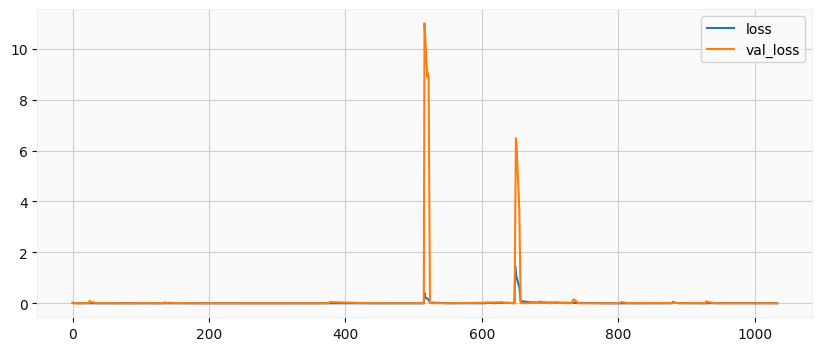

In [141]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(logs[0])
ax.plot(logs[1])
ax.legend(['loss', 'val_loss'])

plt.show()

## III.03 Prediction

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


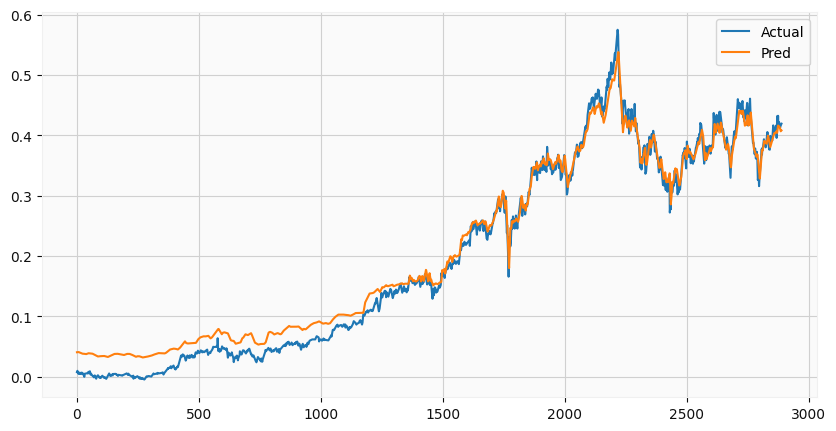

In [142]:
pred =  model.predict(X_val)
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(y_val,label='Actual')
ax.plot(pred,label='Pred')
ax.legend()

In [114]:
y_val.shape,pred.reshape(len(pred)).shape

((2890,), (2890,))

In [144]:
model.save('model_v1_p125.h5')